## Anomaly Detection- Autoencoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import feather
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import random
import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


In [3]:
#winergy data
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83, 85,\
          85, 86, 92, 93, 94, 95, 97]

hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

In [4]:
# getting various turbines raw data having running state from running folder 

def limits(data):
    q1, q3= np.percentile(data,[25,75])
    iqr = q3 - q1 
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku


feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']
feats_2 = ['wind_speed', 'ambient_temperature']
feats_3 = ['failure']

agg_dict = {i:['mean', np.std, rms, kurtosis] for i in feats_1}
agg_dict.update({i:['mean', np.std] for i in feats_2})

def value(data):
    return data.value_counts().index[0]
agg_dict.update({i:[value] for i in feats_3})


def prep_df(turbine_ids):
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        temp_df.drop(['wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault'], axis = 1, inplace = True)
        temp_df['failure'] = 0
                
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        if(pd.notnull(shutdown_date)):
            temp_df.loc[(temp_df.Date <= shutdown_date) & \
                        (temp_df.Date >= (shutdown_date - datetime.timedelta(days=30))), 'failure'] = 1
        
        temp_df = temp_df[(temp_df.Date >= pd.to_datetime("2010-01-01")) &\
                         (temp_df.Date < pd.to_datetime("2014-01-01"))]
        
        for feat in ['power', 'rotor_speed', 'wind_speed', 'gearbox_bearing_temperature', \
                     'gearbox_oil_temperature', 'nacelle_temperature', 'ambient_temperature']:
            l, u = limits(temp_df[feat])
            temp_df.loc[(temp_df[feat] < l) & (temp_df[feat] > u), feat] = temp_df[feat].median() 
        
        df = df.append(temp_df)
    
    df = df.reset_index(drop = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df.fillna(df.mean(), inplace = True)
    
    return df

In [5]:
len(healthy)

31

In [6]:
random.seed(30)
train_ids = random.sample(healthy, k=26)

Data to train various models

In [7]:
train_df = prep_df(train_ids)
train_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,wind_speed_mean,wind_speed_std,ambient_temperature_mean,ambient_temperature_std,failure_value
0,3,2010-01-01,674.513363,500.397497,69.902067,1.628955,15.092565,4.589776,1.314199,6.181490,...,7.270238,12.106499,6.696972,1.152007,1.632289,7.278928,3.425663,7.161534,3.973078,0
1,3,2010-01-02,156.199000,187.334524,20.284203,2.604802,9.591764,5.829685,0.934490,2.119117,...,1.873471,11.441724,4.881814,1.036084,3.481327,3.863227,2.479116,-0.984515,3.005998,0
2,3,2010-01-03,72.534890,82.445805,9.133051,3.803945,9.173306,4.516311,0.851490,3.259598,...,2.454057,13.621354,5.026238,1.209422,5.034011,3.085889,2.029629,-0.717795,2.340862,0
3,3,2010-01-04,125.039468,251.482388,39.398831,3.281520,6.331825,7.037804,1.331406,1.697236,...,2.202140,13.746878,2.354840,1.971857,7.305402,2.385645,2.917620,-1.368597,1.630668,0
4,3,2010-01-05,941.198198,540.820387,90.381506,1.757879,17.070171,2.037740,1.432544,3.869536,...,6.854889,9.031592,4.967071,0.858253,2.262455,9.942076,2.236755,4.266208,1.350742,0


In [8]:
train_df.shape

(35977, 27)

Data of failed turbines

In [9]:
failed_df = prep_df(failed)
failed_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,wind_speed_mean,wind_speed_std,ambient_temperature_mean,ambient_temperature_std,failure_value
0,2,2010-01-01,677.773797,503.445437,70.271028,1.619450,15.062179,4.651560,1.313276,6.355420,...,5.707393,13.702697,4.501151,1.201514,2.498939,7.277473,3.079467,6.931929,3.981962,0
1,2,2010-01-02,297.713840,172.100470,43.238351,1.822747,13.718411,2.314453,1.752397,3.020201,...,5.731830,10.624947,4.842952,1.469107,2.009854,5.751791,1.437250,-1.717805,4.072614,0
2,2,2010-01-03,72.897379,95.302648,9.976900,4.736658,8.540665,4.986558,0.823425,2.240347,...,2.063545,12.523779,3.990492,1.094996,3.664337,3.128424,1.654349,-1.141039,2.316507,0
3,2,2010-01-04,214.171394,250.924840,38.458330,1.745641,8.527414,7.510733,1.326005,1.212858,...,1.166124,10.354646,2.676560,1.251216,4.160120,3.674590,3.086534,-0.935537,2.085430,0
4,2,2010-01-05,948.990019,541.542664,90.975192,1.801376,17.106063,2.029494,1.435434,3.952413,...,6.113759,11.514074,2.744340,0.986200,3.542624,9.689182,2.062327,4.081024,1.416560,0


Data of 5 healthy turbines to validate model

In [10]:
test_healthy = list(set(healthy).difference(train_ids))
healthy_df = prep_df(test_healthy)

healthy_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,wind_speed_mean,wind_speed_std,ambient_temperature_mean,ambient_temperature_std,failure_value
0,37,2010-01-01,666.239822,498.045664,69.232018,1.608800,15.016327,4.823278,1.313901,5.557038,...,5.151267,12.809537,5.873849,1.173630,1.746293,6.991265,3.173567,6.961105,4.003148,0
1,37,2010-01-02,156.456141,196.851352,20.909839,2.106454,9.899774,5.650948,0.949111,2.304370,...,1.808862,11.271325,4.003939,0.996393,4.829231,3.873665,2.459306,-1.531095,2.802188,0
2,37,2010-01-03,21.998822,64.022537,5.623839,8.598940,3.348356,5.034545,0.502647,1.985555,...,1.702554,9.864413,3.360770,0.868120,3.509443,3.184369,1.747947,-0.968633,2.428227,0
3,37,2010-01-04,-3.343621,1.098405,0.562854,5.305572,0.008474,0.005596,0.001620,1.763954,...,2.014057,4.759004,0.381510,0.764433,2.255021,1.134735,0.878254,-2.903802,0.115756,0
4,37,2010-01-05,413.731970,315.706590,66.432617,2.050533,15.463350,2.218752,1.999825,1.564718,...,2.211695,13.484153,3.439897,1.780870,1.677756,8.447402,2.562051,5.622370,0.513102,0


.

In [11]:
import tensorflow as tf
import keras as k
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model, Sequential
from keras import regularizers

Using TensorFlow backend.


## Autoencoder

### Data Preparation

In [12]:
seq_length = 30

feats = train_df.columns.drop(['turbine_id', 'Date', 'failure_value'])

sc = MinMaxScaler()

train_df[feats] = sc.fit_transform(train_df[feats])
failed_df[feats] = sc.transform(failed_df[feats])
healthy_df[feats] = sc.transform(healthy_df[feats])

In [13]:
len(feats)

24

### Model Building

In [14]:
autoencoder = Sequential()
# Encoder
autoencoder.add(Dense(24, activation='relu', input_dim = 24))
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(8, activation='relu'))
# Decoder
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(24, activation='relu'))
# Summary
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                408       
Total params: 1,688
Trainable params: 1,688
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

epochs = 200
batch = 256

autoencoder_history = autoencoder.fit(train_df[feats], train_df[feats], 
                                                epochs = epochs, 
                                                batch_size = batch, 
                                                validation_split = 0.15,
                                                verbose = 1).history

Train on 30580 samples, validate on 5397 samples
Epoch 1/200
30580/30580 [==============================] - 0s 13us/step - loss: 0.0948 - accuracy: 0.0659 - val_loss: 0.0851 - val_accuracy: 0.0630
Epoch 2/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0828 - accuracy: 0.1032 - val_loss: 0.0839 - val_accuracy: 0.0630
Epoch 3/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0600 - accuracy: 0.4642 - val_loss: 0.0519 - val_accuracy: 0.7764
Epoch 4/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0501 - accuracy: 0.8356 - val_loss: 0.0515 - val_accuracy: 0.7941
Epoch 5/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0495 - accuracy: 0.8457 - val_loss: 0.0506 - val_accuracy: 0.8038
Epoch 6/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0485 - accuracy: 0.8562 - val_loss: 0.0498 - val_accuracy: 0.8001
Epoch 7/200
30580/30580 [==============================] - 0s 7us/st

30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9166 - val_loss: 0.0485 - val_accuracy: 0.8434
Epoch 57/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9159 - val_loss: 0.0485 - val_accuracy: 0.8414
Epoch 58/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9160 - val_loss: 0.0485 - val_accuracy: 0.8423
Epoch 59/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9160 - val_loss: 0.0485 - val_accuracy: 0.8427
Epoch 60/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9159 - val_loss: 0.0485 - val_accuracy: 0.8425
Epoch 61/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9153 - val_loss: 0.0485 - val_accuracy: 0.8421
Epoch 62/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9158 - val_loss: 0.0484 

30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9154 - val_loss: 0.0484 - val_accuracy: 0.8464
Epoch 112/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9154 - val_loss: 0.0484 - val_accuracy: 0.8460
Epoch 113/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9159 - val_loss: 0.0484 - val_accuracy: 0.8423
Epoch 114/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9151 - val_loss: 0.0484 - val_accuracy: 0.8462
Epoch 115/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9158 - val_loss: 0.0484 - val_accuracy: 0.8458
Epoch 116/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9156 - val_loss: 0.0484 - val_accuracy: 0.8457
Epoch 117/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9151 - val_loss: 0

30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9159 - val_loss: 0.0484 - val_accuracy: 0.8460
Epoch 167/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9158 - val_loss: 0.0484 - val_accuracy: 0.8488
Epoch 168/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9156 - val_loss: 0.0484 - val_accuracy: 0.8486
Epoch 169/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9168 - val_loss: 0.0484 - val_accuracy: 0.8486
Epoch 170/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9159 - val_loss: 0.0484 - val_accuracy: 0.8468
Epoch 171/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9160 - val_loss: 0.0484 - val_accuracy: 0.8466
Epoch 172/200
30580/30580 [==============================] - 0s 7us/step - loss: 0.0469 - accuracy: 0.9163 - val_loss: 0

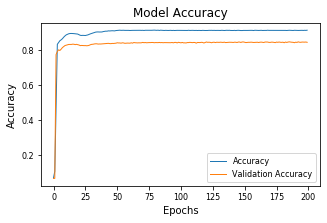

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(autoencoder_history['accuracy'], linewidth = 1, label = "Accuracy")
ax.plot(autoencoder_history['val_accuracy'], linewidth = 1, label = "Validation Accuracy")
ax.legend(loc = 'best', prop={'size': 8})
ax.set_title('Model Accuracy', size = 12)
ax.set_xlabel('Epochs', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_ylabel('Accuracy', size = 10);

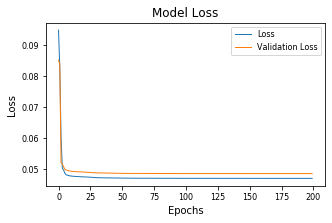

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(autoencoder_history['loss'], linewidth = 1, label = "Loss")
ax.plot(autoencoder_history['val_loss'], linewidth = 1, label = "Validation Loss")
ax.legend(loc = 'best', prop={'size': 8})
ax.set_title('Model Loss', size = 12)
ax.set_xlabel('Epochs', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_ylabel('Loss', size = 10);

### Reconstruction Errors

#### Failed df

In [18]:
failed_preds = autoencoder.predict(failed_df[feats])
failed_preds.shape

(18677, 24)

In [19]:
errors = np.mean(np.abs(failed_preds - failed_df[feats]), axis=1)
errors = [np.mean(i) for i in errors]

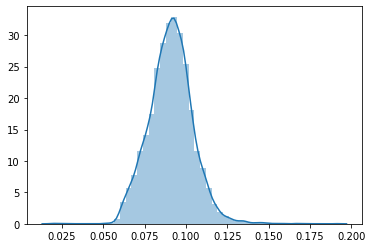

In [20]:
sns.distplot(errors)

In [21]:
temp_failed_df = failed_df.copy()
temp_failed_df['errors'] = errors

In [22]:
len(failed)

13

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


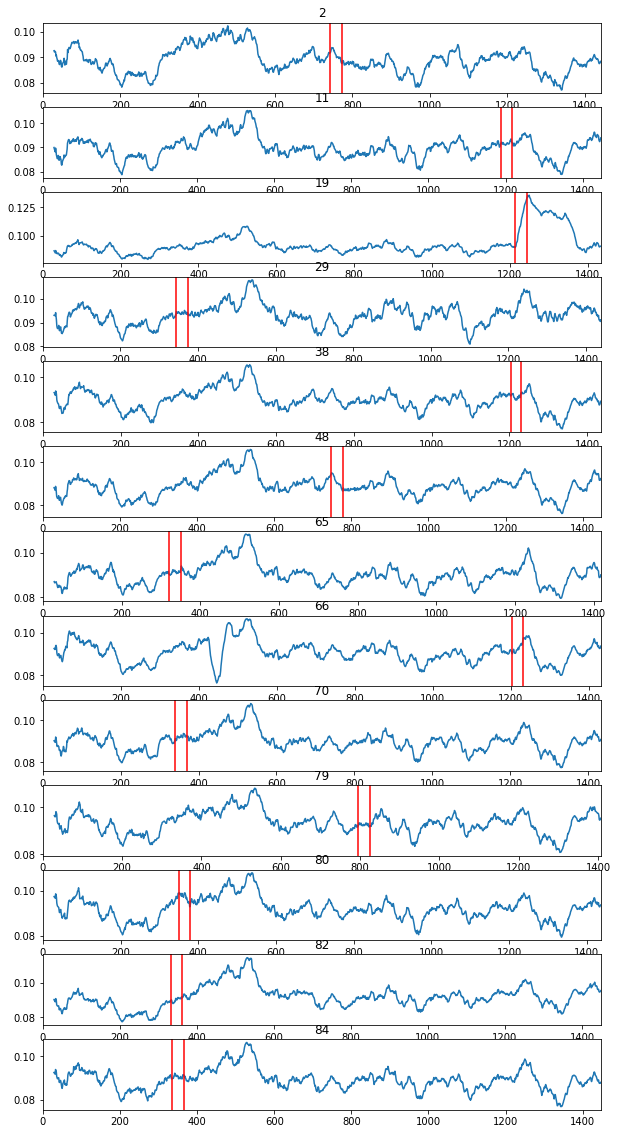

In [28]:
fig, ax = plt.subplots(figsize=(10,20), nrows=13, ncols=1)
i =0 
for key, grp in temp_failed_df.groupby(['turbine_id']):
    grp['errors'] = grp['errors'].rolling(window=30).mean()
    grp = grp.reset_index()
    grp['errors'].plot(kind='line', ax=ax[i], title = key)
    min_ind = grp.index[grp.failure_value == 1].min()
    max_ind = grp.index[grp.failure_value == 1].max()
    
    ax[i].axvline(x=min_ind, color = "red")
    ax[i].axvline(x=max_ind, color = "red")
    
    i = i+1

## LSTM Autoencoder

### Data Preparation

In [23]:
seq_length = 30

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [25]:
feats = train_df.columns.drop(['turbine_id', 'Date', 'failure_value'])

Min-Max Scaler

In [28]:
sc = MinMaxScaler()

train_df[feats] = sc.fit_transform(train_df[feats])
failed_df[feats] = sc.transform(failed_df[feats])
healthy_df[feats] = sc.transform(healthy_df[feats])

In [31]:
print("train_df shape before transformation:", train_df.shape)

train_w = np.concatenate(list(list(gen_sequence(train_df[train_df['turbine_id'] == tid], seq_length, feats)) \
                              for tid in train_df['turbine_id'].unique()))

print("train_w shape after transformation:", train_w.shape)

train_df shape before transformation: (35977, 27)
train_w shape after transformation: (35227, 30, 24)


In [32]:
print("failed_df shape before transformation:", failed_df.shape)

failed_w = np.concatenate(list(list(gen_sequence(failed_df[failed_df['turbine_id'] == tid], seq_length, feats)) \
                              for tid in failed_df['turbine_id'].unique()))

print("failed_w shape after transformation:", failed_w.shape)

failed_df shape before transformation: (18677, 27)
failed_w shape after transformation: (18287, 30, 24)


In [33]:
print("healthy_df shape before transformation:", healthy_df.shape)

healthy_w = np.concatenate(list(list(gen_sequence(healthy_df[healthy_df['turbine_id'] == tid], seq_length, feats)) \
                              for tid in healthy_df['turbine_id'].unique()))

print("healthy_w shape after transformation:", healthy_w.shape)

healthy_df shape before transformation: (7160, 27)
healthy_w shape after transformation: (7010, 30, 24)


### Model Building

In [34]:
timesteps = train_w.shape[1]
n_feats = train_w.shape[2]
(timesteps, n_feats)

(30, 24)

In [36]:
autoencoder_w1 = Sequential()
# Encoder
autoencoder_w1.add(LSTM(32, activation='relu', input_shape=(timesteps, n_feats), return_sequences=True))
autoencoder_w1.add(LSTM(16, activation='relu', return_sequences=False))
autoencoder_w1.add(RepeatVector(timesteps))
# Decoder
autoencoder_w1.add(LSTM(16, activation='relu', return_sequences=True))
autoencoder_w1.add(LSTM(32, activation='relu', return_sequences=True))
autoencoder_w1.add(TimeDistributed(Dense(n_feats)))
# Summary
autoencoder_w1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            7296      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 32)            6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 24)            792       
Total params: 19,608
Trainable params: 19,608
Non-trainable params: 0
__________________________________________________

In [38]:
autoencoder_w1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

epochs = 200
batch = 256

autoencoder_w1_history = autoencoder_w1.fit(train_w, train_w, 
                                                epochs = epochs, 
                                                batch_size = batch, 
                                                validation_split = 0.15,
                                                verbose = 1).history

Train on 29942 samples, validate on 5285 samples
Epoch 1/200
29942/29942 [==============================] - 22s 741us/step - loss: 0.0110 - accuracy: 0.8040 - val_loss: 0.0092 - val_accuracy: 0.7860
Epoch 2/200
29942/29942 [==============================] - 21s 708us/step - loss: 0.0086 - accuracy: 0.8301 - val_loss: 0.0086 - val_accuracy: 0.7936
Epoch 3/200
29942/29942 [==============================] - 22s 726us/step - loss: 0.0081 - accuracy: 0.8359 - val_loss: 0.0083 - val_accuracy: 0.7949
Epoch 4/200
29942/29942 [==============================] - 20s 684us/step - loss: 0.0078 - accuracy: 0.8366 - val_loss: 0.0081 - val_accuracy: 0.7947
Epoch 5/200
29942/29942 [==============================] - 22s 728us/step - loss: 0.0076 - accuracy: 0.8371 - val_loss: 0.0080 - val_accuracy: 0.7949
Epoch 6/200
29942/29942 [==============================] - 19s 629us/step - loss: 0.0075 - accuracy: 0.8377 - val_loss: 0.0079 - val_accuracy: 0.7946
Epoch 7/200
29942/29942 [==========================

29942/29942 [==============================] - 24s 798us/step - loss: 0.0066 - accuracy: 0.8406 - val_loss: 0.0070 - val_accuracy: 0.7959
Epoch 56/200
29942/29942 [==============================] - 20s 671us/step - loss: 0.0066 - accuracy: 0.8407 - val_loss: 0.0070 - val_accuracy: 0.7962
Epoch 57/200
29942/29942 [==============================] - 19s 648us/step - loss: 0.0066 - accuracy: 0.8404 - val_loss: 0.0070 - val_accuracy: 0.7961
Epoch 58/200
29942/29942 [==============================] - 19s 635us/step - loss: 0.0066 - accuracy: 0.8405 - val_loss: 0.0070 - val_accuracy: 0.7965
Epoch 59/200
29942/29942 [==============================] - 19s 621us/step - loss: 0.0066 - accuracy: 0.8404 - val_loss: 0.0070 - val_accuracy: 0.7966
Epoch 60/200
29942/29942 [==============================] - 19s 626us/step - loss: 0.0066 - accuracy: 0.8405 - val_loss: 0.0070 - val_accuracy: 0.7965
Epoch 61/200
29942/29942 [==============================] - 19s 622us/step - loss: 0.0066 - accuracy: 0.840

Epoch 163/200
29942/29942 [==============================] - 18s 607us/step - loss: 0.0060 - accuracy: 0.8445 - val_loss: 0.0063 - val_accuracy: 0.7979
Epoch 164/200
29942/29942 [==============================] - 19s 635us/step - loss: 0.0060 - accuracy: 0.8446 - val_loss: 0.0063 - val_accuracy: 0.7973
Epoch 165/200
29942/29942 [==============================] - 18s 606us/step - loss: 0.0060 - accuracy: 0.8445 - val_loss: 0.0063 - val_accuracy: 0.7975
Epoch 166/200
29942/29942 [==============================] - 18s 613us/step - loss: 0.0060 - accuracy: 0.8448 - val_loss: 0.0063 - val_accuracy: 0.7980
Epoch 167/200
29942/29942 [==============================] - 18s 615us/step - loss: 0.0060 - accuracy: 0.8445 - val_loss: 0.0063 - val_accuracy: 0.7962
Epoch 168/200
29942/29942 [==============================] - 18s 608us/step - loss: 0.0060 - accuracy: 0.8446 - val_loss: 0.0063 - val_accuracy: 0.7973
Epoch 169/200
29942/29942 [==============================] - 18s 609us/step - loss: 0.00

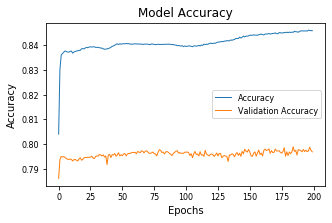

In [39]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(autoencoder_w1_history['accuracy'], linewidth = 1, label = "Accuracy")
ax.plot(autoencoder_w1_history['val_accuracy'], linewidth = 1, label = "Validation Accuracy")
ax.legend(loc = 'best', prop={'size': 8})
ax.set_title('Model Accuracy', size = 12)
ax.set_xlabel('Epochs', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_ylabel('Accuracy', size = 10);

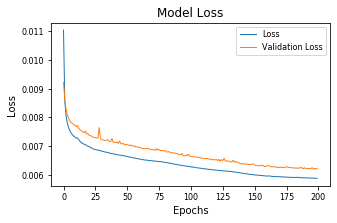

In [40]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(autoencoder_w1_history['loss'], linewidth = 1, label = "Loss")
ax.plot(autoencoder_w1_history['val_loss'], linewidth = 1, label = "Validation Loss")
ax.legend(loc = 'best', prop={'size': 8})
ax.set_title('Model Loss', size = 12)
ax.set_xlabel('Epochs', size = 10)
ax.tick_params(axis = 'both', labelsize = 8)
ax.set_ylabel('Loss', size = 10);

### Reconstruction Errors

#### Failed df

In [42]:
failed_w.shape

(18287, 30, 24)

In [41]:
failed_w_preds = autoencoder_w1.predict(failed_w)
failed_w_preds.shape

(18287, 30, 24)

In [49]:
errors = np.mean(np.abs(failed_w_preds - failed_w), axis=1)
errors = [np.mean(i) for i in errors]

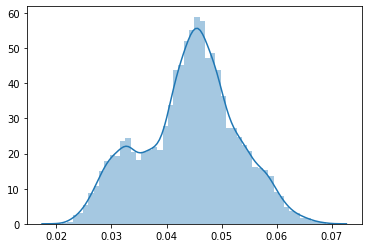

In [50]:
sns.distplot(errors)

In [57]:
final_failed_df = failed_df.groupby('turbine_id').apply(lambda group: group.iloc[30:, 1:]).reset_index()
final_failed_df['errors'] = errors

In [58]:
len(failed)

13

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


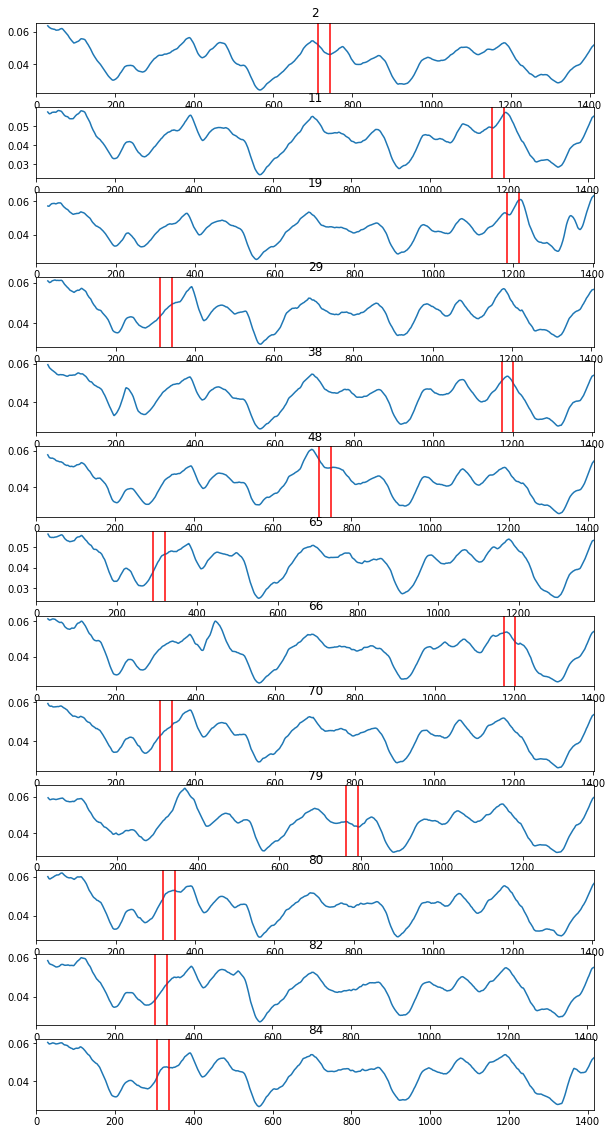

In [76]:
fig, ax = plt.subplots(figsize=(10,20), nrows=13, ncols=1)
i =0 
for key, grp in final_failed_df.groupby(['turbine_id']):
    grp['errors'] = grp['errors'].rolling(window=30).mean()
    grp = grp.reset_index()
    grp['errors'].plot(kind='line', ax=ax[i], title = key)
    min_ind = grp.index[grp.failure_value == 1].min()
    max_ind = grp.index[grp.failure_value == 1].max()
    
    ax[i].axvline(x=min_ind, color = "red")
    ax[i].axvline(x=max_ind, color = "red")
    
    i = i+1

#### Healthy df

In [65]:
healthy_w.shape

(7010, 30, 24)

In [66]:
healthy_w_preds = autoencoder_w1.predict(healthy_w)
healthy_w_preds.shape

(7010, 30, 24)

In [67]:
errors = np.mean(np.abs(healthy_w_preds - healthy_w), axis=1)
errors = [np.mean(i) for i in errors]

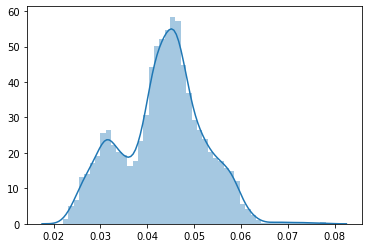

In [68]:
sns.distplot(errors)

In [69]:
final_healthy_df = healthy_df.groupby('turbine_id').apply(lambda group: group.iloc[30:, 1:]).reset_index()
final_healthy_df['errors'] = errors

In [71]:
len(test_healthy)

5

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


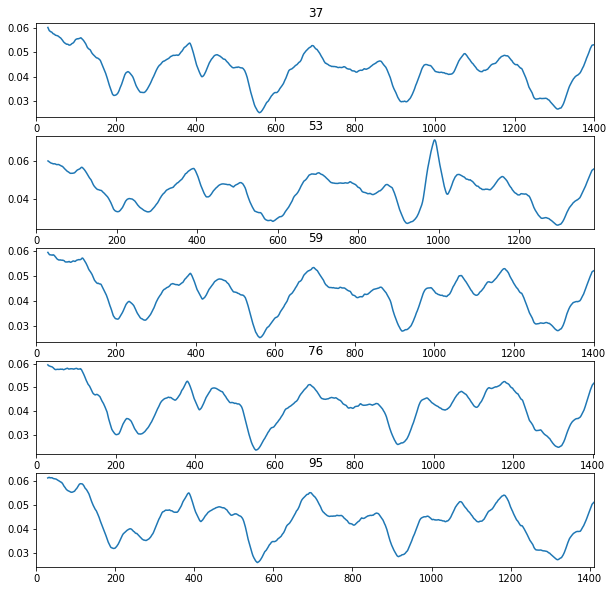

In [77]:
fig, ax = plt.subplots(figsize=(10,10), nrows=5, ncols=1)
i =0 
for key, grp in final_healthy_df.groupby(['turbine_id']):
    grp['errors'] = grp['errors'].rolling(window=30).mean()
    grp = grp.reset_index()
    grp['errors'].plot(kind='line', ax=ax[i], title = key)
    
    i = i+1